In [1]:
 from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"narendrakanumuri","key":"3f2381d5bf5273f49a3c30581cc755bb"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip -d fashion_data


Streaming output truncated to the last 5000 lines.
  inflating: fashion_data/myntradataset/images/5813.jpg  
  inflating: fashion_data/myntradataset/images/58131.jpg  
  inflating: fashion_data/myntradataset/images/58132.jpg  
  inflating: fashion_data/myntradataset/images/58133.jpg  
  inflating: fashion_data/myntradataset/images/58135.jpg  
  inflating: fashion_data/myntradataset/images/58136.jpg  
  inflating: fashion_data/myntradataset/images/58137.jpg  
  inflating: fashion_data/myntradataset/images/58138.jpg  
  inflating: fashion_data/myntradataset/images/58139.jpg  
  inflating: fashion_data/myntradataset/images/5814.jpg  
  inflating: fashion_data/myntradataset/images/58140.jpg  
  inflating: fashion_data/myntradataset/images/58141.jpg  
  inflating: fashion_data/myntradataset/images/58143.jpg  
  inflating: fashion_data/myntradataset/images/58144.jpg  
  inflating: fashion_data/myntradataset/images/58145.jpg  
  inflating: fashion_data/myntradataset/images/58146.jpg  
  infla

In [4]:
import pandas as pd

# Load the CSV while skipping bad lines
df = pd.read_csv('fashion_data/styles.csv', on_bad_lines='skip')

print("Shape:", df.shape)
df.head()


Shape: (44424, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [5]:
import os
IMAGE_DIR = "fashion_data/images"
# Filter for apparel category only
apparel_df = df[df['masterCategory'] == 'Apparel'].copy()
print("✅ Apparel entries:", len(apparel_df))

# Add image filename
apparel_df['image'] = apparel_df['id'].astype(str) + '.jpg'

# Filter rows where image file actually exists
apparel_df = apparel_df[apparel_df['image'].apply(lambda x: os.path.isfile(os.path.join(IMAGE_DIR, x)))]
print("✅ Apparel images that exist:", len(apparel_df))

# Add a new column as the "caption" using the productDisplayName
apparel_df['caption'] = apparel_df['productDisplayName']
apparel_df = apparel_df[['image', 'caption']]  # Keep only required columns

# Preview
apparel_df.head()


✅ Apparel entries: 21397
✅ Apparel images that exist: 21392


,image,caption
0,15970.jpg,Turtle Check Men Navy Blue Shirt
1,39386.jpg,Peter England Men Party Blue Jeans
3,21379.jpg,Manchester United Men Solid Black Track Pants
4,53759.jpg,Puma Men Grey T-shirt
5,1855.jpg,Inkfruit Mens Chain Reaction T-shirt


In [6]:
apparel_df.to_csv("apparel_captions.csv", index=False)
print("✅ Saved to apparel_captions.csv")


✅ Saved to apparel_captions.csv


In [7]:
!pip install timm
import timm
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from tqdm import tqdm
import numpy as np

# Load pretrained ConvNeXt-Large
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('convnext_large', pretrained=True, num_classes=0)
model = model.to(device)
model.eval()
print("✅ Loaded ConvNeXt-Large model")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

✅ Loaded ConvNeXt-Large model


In [8]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet means
        std=[0.229, 0.224, 0.225]    # ImageNet stds
    )
])


In [9]:
def extract_features(image_path, model, transform, device):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        features = model(image)
    return features.squeeze(0).cpu()  # Remove batch dim and move to CPU


In [10]:
image_path = "fashion_data/images/1855.jpg"  # or any uploaded image
features = extract_features(image_path, model, transform, device)
print("✅ Feature vector shape:", features.shape)

✅ Feature vector shape: torch.Size([1536])


In [11]:
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch

# Load apparel captions
apparel_df = pd.read_csv("apparel_captions.csv")
IMAGE_DIR = "fashion_data/images"

# Only keep entries where the image file exists
apparel_df['full_path'] = apparel_df['image'].apply(lambda x: os.path.join(IMAGE_DIR, x))
apparel_df = apparel_df[apparel_df['full_path'].apply(os.path.exists)]

# Shuffle and select only 1000 images
apparel_df = apparel_df.sample(n=1000, random_state=42).reset_index(drop=True)

# Confirm
print("✅ Selected 1000 images. Example entries:")
print(apparel_df.head())

# Store all features in a list
features_list = []
valid_captions = []

for img_name, caption in tqdm(zip(apparel_df['image'], apparel_df['caption']), total=len(apparel_df)):
    img_path = os.path.join(IMAGE_DIR, img_name)
    try:
        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            feature = model(image).squeeze().cpu().numpy()  # 1536-dim output
        features_list.append(feature)
        valid_captions.append(caption)
    except Exception as e:
        print(f"❌ Failed on {img_name}: {e}")

print("✅ Feature extraction done. Total features:", len(features_list))


✅ Selected 1000 images. Example entries:
       image                                            caption  \
0  46733.jpg               Gini and Jony Girls Navy Blue Capris   
1  12069.jpg                       W Women Printed White Kurtas   
2  57346.jpg                            Amante White Bra-BGEC01   
3  19530.jpg  United Colors of Benetton Men Stripes Navy Blu...   
4   5174.jpg             Inkfruit Women's Hip Huraa Red T-shirt   

                       full_path  
0  fashion_data/images/46733.jpg  
1  fashion_data/images/12069.jpg  
2  fashion_data/images/57346.jpg  
3  fashion_data/images/19530.jpg  
4   fashion_data/images/5174.jpg  


100%|██████████| 1000/1000 [02:01<00:00,  8.22it/s]

✅ Feature extraction done. Total features: 1000


In [12]:
import pickle

# Save image features
with open("image_features.pkl", "wb") as f:
    pickle.dump(features_list, f)

# Save captions
with open("captions.pkl", "wb") as f:
    pickle.dump(valid_captions, f)

print("✅ Saved image features and captions as .pkl files")


✅ Saved image features and captions as .pkl files


In [13]:
# ✅ Step 1: Ensure nltk resources are available
import nltk
nltk.download('punkt')  # Required for tokenization
nltk.download('punkt_tab')  # (if needed)

# ✅ Step 2: Required libraries
import re
from nltk.tokenize import word_tokenize
import pickle

# ✅ Step 3: Load the filtered 1000 captions
with open("captions.pkl", "rb") as f:
    raw_captions = pickle.load(f)

print(f"✅ Loaded {len(raw_captions)} filtered captions")

# ✅ Step 4: Define caption cleaning function
def clean_caption(caption):

    caption = re.sub(r"[^a-zA-Z0-9\s]", "", caption)  # Remove punctuation
    caption = re.sub(r"\s+", " ", caption).strip()    # Normalize whitespace
    return caption

# ✅ Step 5: Clean and tokenize
tokenized_captions = []
for cap in raw_captions:
    cleaned = clean_caption(cap)
    tokens = word_tokenize(cleaned)
    tokenized_captions.append(tokens)

# ✅ Step 6: Sample output for verification
print("\n✅ Tokenization complete. Sample:\n")
for i in range(3):
    print(f"Original: {raw_captions[i]}")
    print(f"Cleaned : {clean_caption(raw_captions[i])}")
    print(f"Tokens  : {tokenized_captions[i]}\n")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ Loaded 1000 filtered captions

✅ Tokenization complete. Sample:

Original: Gini and Jony Girls Navy Blue Capris
Cleaned : Gini and Jony Girls Navy Blue Capris
Tokens  : ['Gini', 'and', 'Jony', 'Girls', 'Navy', 'Blue', 'Capris']

Original: W Women Printed White Kurtas
Cleaned : W Women Printed White Kurtas
Tokens  : ['W', 'Women', 'Printed', 'White', 'Kurtas']

Original: Amante White Bra-BGEC01
Cleaned : Amante White BraBGEC01
Tokens  : ['Amante', 'White', 'BraBGEC01']



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [14]:
from collections import Counter

# Count word frequencies
word_counts = Counter(word for caption in tokenized_captions for word in caption)

# 🔁 Reduce minimum frequency
min_word_freq = 1  # or 1 if you want to keep even rare words

words = [word for word, count in word_counts.items() if count >= min_word_freq]


# ✅ Add special tokens
words = ['<pad>', '<start>', '<end>', '<unk>'] + words

# ✅ Create vocab-to-index and index-to-vocab maps
word2idx = {word: idx for idx, word in enumerate(words)}
idx2word = {idx: word for word, idx in word2idx.items()}

# ✅ Vocabulary size
vocab_size = len(word2idx)
print(f"✅ Vocabulary size: {vocab_size}")
print("🧾 Sample word2idx mapping:\n", dict(list(word2idx.items())[:10]))


✅ Vocabulary size: 802
🧾 Sample word2idx mapping:
 {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3, 'Gini': 4, 'and': 5, 'Jony': 6, 'Girls': 7, 'Navy': 8, 'Blue': 9}


In [15]:
encoded_captions = []

for tokens in tokenized_captions:
    encoded = [word2idx.get('<start>')]  # Start token
    for token in tokens:
        encoded.append(word2idx.get(token, word2idx['<unk>']))  # Word or <unk>
    encoded.append(word2idx.get('<end>'))  # End token
    encoded_captions.append(encoded)

# 🔍 Print 1st example
print("✅ Sample encoded caption:\n", encoded_captions[0])


✅ Sample encoded caption:
 [1, 4, 5, 6, 7, 8, 9, 10, 2]


In [16]:
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)

with open("idx2word.pkl", "wb") as f:
    pickle.dump(idx2word, f)

with open("encoded_captions.pkl", "wb") as f:
    pickle.dump(encoded_captions, f)

print("✅ Saved encoded captions and vocabulary")


✅ Saved encoded captions and vocabulary


In [17]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Convert each tokenized caption to a sequence of indices
def encode_caption(tokens, word2idx):
    tokens = ['<start>'] + tokens + ['<end>']
    return torch.tensor([word2idx.get(word, word2idx['<unk>']) for word in tokens], dtype=torch.long)

encoded_captions = [encode_caption(caption, word2idx) for caption in tokenized_captions]

# Pad the sequences to same length
padded_captions = pad_sequence(encoded_captions, batch_first=True, padding_value=word2idx['<pad>'])

print(f"✅ Sample encoded caption:\n{encoded_captions[0]}")
print(f"✅ Padded caption shape: {padded_captions.shape}")


✅ Sample encoded caption:
tensor([ 1,  4,  5,  6,  7,  8,  9, 10,  2])
✅ Padded caption shape: torch.Size([1000, 13])


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(BahdanauAttention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)

    def forward(self, encoder_outputs, hidden_state):
        # encoder_outputs: (batch_size, num_pixels, encoder_dim)
        # hidden_state: (batch_size, decoder_dim)

        att1 = self.encoder_att(encoder_outputs)          # (B, num_pixels, att_dim)
        att2 = self.decoder_att(hidden_state).unsqueeze(1) # (B, 1, att_dim)

        att = torch.tanh(att1 + att2)                     # (B, num_pixels, att_dim)
        e = self.full_att(att).squeeze(2)                 # (B, num_pixels)
        alpha = F.softmax(e, dim=1)                       # (B, num_pixels)
        context = (encoder_outputs * alpha.unsqueeze(2)).sum(dim=1)  # (B, encoder_dim)
        return context, alpha

In [19]:
class AttentionDecoder(nn.Module):
    def __init__(self, embed_size, decoder_dim, vocab_size, encoder_dim=1536, attention_dim=512):
        super(AttentionDecoder, self).__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.attention = BahdanauAttention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTMCell(embed_size + encoder_dim, decoder_dim)
        self.fc = nn.Linear(decoder_dim, vocab_size)

    def forward(self, encoder_outputs, captions):
        batch_size = encoder_outputs.size(0)
        num_pixels = encoder_outputs.size(1)
        caption_len = captions.size(1)

        embeddings = self.embedding(captions)  # (B, T, embed)
        h, c = self.init_hidden_state(batch_size)

        outputs = torch.zeros(batch_size, caption_len, self.vocab_size).to(encoder_outputs.device)

        for t in range(caption_len):
            context, _ = self.attention(encoder_outputs, h)  # (B, encoder_dim)

            lstm_input = torch.cat((embeddings[:, t], context), dim=1)  # (B, embed + encoder_dim)
            h, c = self.lstm(lstm_input, (h, c))
            output = self.fc(self.dropout(h))  # (B, vocab)
            outputs[:, t] = output

        return outputs

    def init_hidden_state(self, batch_size):
        h = torch.zeros(batch_size, self.decoder_dim).to(device)
        c = torch.zeros(batch_size, self.decoder_dim).to(device)
        return h, c


In [20]:
def prepare_encoder_output(image_tensor, convnext_model):
    with torch.no_grad():
        features = convnext_model(image_tensor).squeeze(0)  # (1536,)
    return features.unsqueeze(0)  # Make batch dim (1, 1536)


In [21]:
def extract_feature_map(image_tensor, convnext_model):
    with torch.no_grad():
        # Extract feature map from intermediate layer if needed
        feature_map = convnext_model.forward_features(image_tensor.unsqueeze(0))  # (1, 1536, 16, 16)
        reshaped = feature_map.view(1, 1536, -1).permute(0, 2, 1)  # (1, 256, 1536)
    return reshaped  # (batch_size, num_pixels=256, encoder_dim)


In [22]:
def generate_caption_with_attention(model, encoder_output, word2idx, idx2word, max_len=20):
    model.eval()
    caption = []
    word = torch.tensor([word2idx['<start>']]).to(device)
    h, c = model.init_hidden_state(1)

    for _ in range(max_len):
        embed = model.embedding(word).squeeze(1)  # Squeeze the middle dimension
        context, _ = model.attention(encoder_output, h)
        lstm_input = torch.cat((embed, context), dim=1)
        h, c = model.lstm(lstm_input, (h, c))
        output = model.fc(h)
        predicted = output.argmax(1)
        word = predicted.unsqueeze(0)

        next_word = idx2word[predicted.item()]
        if next_word == '<end>':
            break
        caption.append(next_word)

    return " ".join(caption)

In [23]:
from torch.utils.data import Dataset

class FashionCaptionDataset(Dataset):
    def __init__(self, features, captions):
        self.features = features
        self.captions = captions

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        caption = torch.tensor(self.captions[idx], dtype=torch.long)
        return feature, caption


In [24]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# Load from pickle
with open("image_features.pkl", "rb") as f:
    features_list = pickle.load(f)
with open("encoded_captions.pkl", "rb") as f:
    encoded_captions = pickle.load(f)

def collate_fn(batch):
    features, captions = zip(*batch)
    features = torch.stack(features, 0)
    # Correctly handle padding using the loaded word2idx
    captions = pad_sequence([torch.tensor(c) for c in captions], batch_first=True, padding_value=word2idx['<pad>'])
    return features, captions

dataset = FashionCaptionDataset(features_list, encoded_captions)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

print("✅ DataLoader ready. Total batches:", len(train_loader))

✅ DataLoader ready. Total batches: 32


In [25]:
embed_size = 256
decoder_dim = 512
attention_dim = 512
encoder_dim = 1536  # From convnext_large

decoder = AttentionDecoder(embed_size, decoder_dim, vocab_size, encoder_dim, attention_dim).to(device)


In [26]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])
optimizer = optim.Adam(decoder.parameters(), lr=1e-3)


In [27]:
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
import torch

EPOCHS = 30

losses = []
bleu1_scores, bleu2_scores, bleu3_scores, bleu4_scores = [], [], [], []

def train_one_epoch(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_loss = 0

    for features, captions in dataloader:
        features = features.to(device)           # (B, 1536)
        captions = captions.to(device)           # (B, T)

        # Expand feature to simulate spatial structure for attention
        encoder_out = features.unsqueeze(1).expand(-1, 256, -1)  # (B, 256, 1536)

        outputs = model(encoder_out, captions[:, :-1])           # Predict next word
        loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def compute_bleu_scores(references, hypotheses):
    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu1, bleu2, bleu3, bleu4

# 🧠 Run training for 30 epochs
for epoch in range(EPOCHS):
    loss = train_one_epoch(train_loader, decoder, criterion, optimizer, device)
    losses.append(loss)

    # 🔍 Evaluation: Predict on a small batch
    actual_captions = []
    predicted_captions = []

    decoder.eval()
    with torch.no_grad():
        for features, caps in train_loader:
            features = features.to(device)
            caps = caps.to(device)

            encoder_out = features.unsqueeze(1).expand(-1, 256, -1)

            for i in range(features.size(0)):
                pred_tokens = generate_caption_with_attention(decoder, encoder_out[i].unsqueeze(0), word2idx, idx2word)
                true_tokens = [idx2word[idx.item()] for idx in caps[i] if idx.item() not in [word2idx['<pad>']]]

                actual_captions.append([true_tokens])
                predicted_captions.append(pred_tokens.split())

            break  # 🛑 Optional: only check on one batch for speed

    bleu1, bleu2, bleu3, bleu4 = compute_bleu_scores(actual_captions, predicted_captions)
    bleu1_scores.append(bleu1)
    bleu2_scores.append(bleu2)
    bleu3_scores.append(bleu3)
    bleu4_scores.append(bleu4)

    print(f"✅ Epoch {epoch+1}/{EPOCHS}, Loss: {loss:.4f} | BLEU-1: {bleu1:.4f}, BLEU-2: {bleu2:.4f}, BLEU-3: {bleu3:.4f}, BLEU-4: {bleu4:.4f}")

# 💾 Save the trained model
torch.save(decoder.state_dict(), "fashion_caption_model.pth")
print("✅ Model training completed and saved as 'fashion_caption_model.pth'")

/tmp/ipython-input-3616587482.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  captions = pad_sequence([torch.tensor(c) for c in captions], batch_first=True, padding_value=word2idx['<pad>'])
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  war

✅ Epoch 1/30, Loss: 4.6568 | BLEU-1: 0.1301, BLEU-2: 0.0438, BLEU-3: 0.0000, BLEU-4: 0.0000
✅ Epoch 2/30, Loss: 3.4877 | BLEU-1: 0.2415, BLEU-2: 0.1658, BLEU-3: 0.1238, BLEU-4: 0.0939
✅ Epoch 3/30, Loss: 2.9301 | BLEU-1: 0.2438, BLEU-2: 0.1499, BLEU-3: 0.1060, BLEU-4: 0.0782
✅ Epoch 4/30, Loss: 2.5257 | BLEU-1: 0.2755, BLEU-2: 0.1915, BLEU-3: 0.1368, BLEU-4: 0.0955
✅ Epoch 5/30, Loss: 2.2496 | BLEU-1: 0.3544, BLEU-2: 0.2585, BLEU-3: 0.1808, BLEU-4: 0.1248
✅ Epoch 6/30, Loss: 2.0314 | BLEU-1: 0.3300, BLEU-2: 0.2547, BLEU-3: 0.2042, BLEU-4: 0.1629
✅ Epoch 7/30, Loss: 1.8320 | BLEU-1: 0.3355, BLEU-2: 0.2284, BLEU-3: 0.1533, BLEU-4: 0.0974
✅ Epoch 8/30, Loss: 1.6469 | BLEU-1: 0.3417, BLEU-2: 0.2463, BLEU-3: 0.1840, BLEU-4: 0.1485
✅ Epoch 9/30, Loss: 1.4938 | BLEU-1: 0.3959, BLEU-2: 0.3023, BLEU-3: 0.2328, BLEU-4: 0.1752
✅ Epoch 10/30, Loss: 1.3581 | BLEU-1: 0.4054, BLEU-2: 0.3242, BLEU-3: 0.2750, BLEU-4: 0.2416
✅ Epoch 11/30, Loss: 1.2306 | BLEU-1: 0.3616, BLEU-2: 0.2935, BLEU-3: 0.2532, B

In [28]:
# Load vocabulary
import pickle

with open("word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)
with open("idx2word.pkl", "rb") as f:
    idx2word = pickle.load(f)

# Re-initialize decoder
vocab_size = len(word2idx)
embed_size = 256
decoder_dim = 512
attention_dim = 512
encoder_dim = 1536

decoder = AttentionDecoder(embed_size, decoder_dim, vocab_size, encoder_dim, attention_dim)
decoder.load_state_dict(torch.load("fashion_caption_model.pth", map_location=device))
decoder.to(device)
decoder.eval()
print("✅ Decoder model loaded")

✅ Decoder model loaded


In [29]:
def generate_caption(decoder, image_feature, word2idx, idx2word, max_len=20):
    decoder.eval()
    with torch.no_grad():
        image_feature = image_feature.unsqueeze(0).to(device)  # [1, 1536]

        caption = [word2idx['<start>']]

        for _ in range(max_len):
            cap_tensor = torch.tensor(caption).unsqueeze(0).to(device)  # [1, current_seq_len]
            output = decoder(image_feature, cap_tensor)  # [1, seq_len, vocab_size]
            next_token = output.argmax(2)[:, -1].item()  # Take last token prediction
            caption.append(next_token)

            if next_token == word2idx['<end>']:
                break

        decoded = [idx2word[idx] for idx in caption[1:-1]]  # Exclude <start> and <end>
        return " ".join(decoded)


In [30]:
from PIL import Image

# Choose an image from the dataframe
image_path = apparel_df.loc[0, 'full_path']

# Load and preprocess image
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).to(device)

features = model(image_tensor.unsqueeze(0)).squeeze()
print(features.shape)  # This should print: torch.Size([1536])

torch.Size([1536])


In [31]:
from PIL import Image

# Choose an image from the dataframe
image_path = apparel_df.loc[0, 'full_path']

# Load and preprocess image
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).to(device)

# Get feature vector
features = model(image_tensor.unsqueeze(0)).squeeze()

# Generate caption
caption = generate_caption(decoder, features, word2idx, idx2word)
print("🧾 Caption:", caption)

🧾 Caption: Gini and Jony Girls Navy Blue Capris


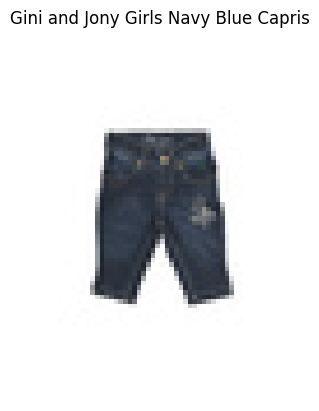

In [32]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.axis('off')
plt.title(caption)
plt.show()


In [33]:
from PIL import Image
import torchvision.transforms as transforms

# Define image transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Choose a few random test images
for i in range(5):
    image_path = apparel_df.loc[i, 'full_path']
    true_caption = apparel_df.loc[i, 'caption']

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).to(device)
    features = model(image_tensor.unsqueeze(0)).squeeze()

    # Generate caption
    pred_caption = generate_caption(decoder, features, word2idx, idx2word)

    # Display results
    print(f"\n🖼️ Image: {image_path}")
    print(f"🧾 Predicted: {pred_caption}")
    print(f"🎯 Actual   : {true_caption}")



🖼️ Image: fashion_data/images/46733.jpg
🧾 Predicted: Gini and Jony Girls Navy Blue Capris
🎯 Actual   : Gini and Jony Girls Navy Blue Capris

🖼️ Image: fashion_data/images/12069.jpg
🧾 Predicted: W Women Printed White Kurtas
🎯 Actual   : W Women Printed White Kurtas

🖼️ Image: fashion_data/images/57346.jpg
🧾 Predicted: Amante White BraBGEC01
🎯 Actual   : Amante White Bra-BGEC01

🖼️ Image: fashion_data/images/19530.jpg
🧾 Predicted: United Colors of Benetton Men Stripes Navy Blue Sweater
🎯 Actual   : United Colors of Benetton Men Stripes Navy Blue Sweater

🖼️ Image: fashion_data/images/5174.jpg
🧾 Predicted: Inkfruit Womens Hip Huraa Red Tshirt
🎯 Actual   : Inkfruit Women's Hip Huraa Red T-shirt


In [34]:
from nltk.translate.bleu_score import corpus_bleu

# Load saved features and captions
with open("image_features.pkl", "rb") as f:
    val_features = pickle.load(f)
with open("captions.pkl", "rb") as f:
    val_captions = pickle.load(f)

refs = []
hyps = []

for i in range(len(val_features)):
    image_tensor = torch.tensor(val_features[i], dtype=torch.float32).to(device)
    pred = generate_caption(decoder, image_tensor, word2idx, idx2word)
    pred_tokens = pred.split()

    # Actual reference
    true_cap = clean_caption(val_captions[i])
    ref_tokens = word_tokenize(true_cap)

    hyps.append(pred_tokens)
    refs.append([ref_tokens])  # BLEU expects list of references

# Calculate BLEU score
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
score = corpus_bleu(refs, hyps, smoothing_function=SmoothingFunction().method1)
print(f"\n✅ Final BLEU-4 Score: {score:.4f}")



✅ Final BLEU-4 Score: 0.9324


In [35]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smooth = SmoothingFunction().method1

# BLEU-1: 1-gram
bleu1 = corpus_bleu(refs, hyps, weights=(1.0, 0, 0, 0), smoothing_function=smooth)

# BLEU-2: 1-gram + 2-gram
bleu2 = corpus_bleu(refs, hyps, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)

# BLEU-3: 1-gram + 2-gram + 3-gram
bleu3 = corpus_bleu(refs, hyps, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)

# BLEU-4: 1-gram + 2-gram + 3-gram + 4-gram
bleu4 = corpus_bleu(refs, hyps, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

print(f"\n✅ Final BLEU-1 Score: {bleu1:.4f}")
print(f"✅ Final BLEU-2 Score: {bleu2:.4f}")
print(f"✅ Final BLEU-3 Score: {bleu3:.4f}")
print(f"✅ Final BLEU-4 Score: {bleu4:.4f}")



✅ Final BLEU-1 Score: 0.9543
✅ Final BLEU-2 Score: 0.9437
✅ Final BLEU-3 Score: 0.9381
✅ Final BLEU-4 Score: 0.9324


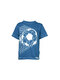

🧾 Predicted: Doodle Kids Boys Soccer Blue TShirt
🎯 Actual   : Doodle Kids Boys Soccer Blue T-Shirt


In [55]:
import random
from IPython.display import Image as IPyImage, display

# Pick a random image from the dataset
idx = random.randint(0, len(apparel_df) - 1)
image_path = apparel_df.loc[idx, 'full_path']
actual_caption = apparel_df.loc[idx, 'caption']

# Load and preprocess image
image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).to(device)
features = model(image_tensor.unsqueeze(0)).squeeze()

# Generate caption
predicted_caption = generate_caption(decoder, features, word2idx, idx2word)

# Display
display(IPyImage(filename=image_path))
print("🧾 Predicted:", predicted_caption)
print("🎯 Actual   :", actual_caption)


In [37]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [38]:
import os

# Define base path to videos
video_folder = "/content/drive/MyDrive/videos"
video_files = ["video.mp4", "video1.mp4", "video2.mp4"]

# Frame output base directory
output_base = "/content/video_frames"
os.makedirs(output_base, exist_ok=True)


In [39]:
import cv2

def extract_frames(video_path, output_dir, fps=1):
    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_rate = int(cap.get(cv2.CAP_PROP_FPS)) or 25
    count = 0
    saved = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % int(frame_rate / fps) == 0:
            frame_path = os.path.join(output_dir, f"frame_{saved:03d}.jpg")
            cv2.imwrite(frame_path, frame)
            saved += 1
        count += 1

    cap.release()
    print(f"✅ Extracted {saved} frames from {video_path}")


In [40]:
from PIL import Image

def generate_captions_for_frames(frame_dir, model, decoder, transform, word2idx, idx2word):
    results = []
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith('.jpg')])

    for fname in frame_files:
        path = os.path.join(frame_dir, fname)
        image = Image.open(path).convert("RGB")
        image_tensor = transform(image).to(device)

        with torch.no_grad():
            features = model(image_tensor.unsqueeze(0)).squeeze()

        caption = generate_caption(decoder, features, word2idx, idx2word)
        results.append((fname, caption))
        print(f"🖼️ {fname}: {caption}")

    return results


In [41]:
import csv

def save_captions(captions, filename):
    with open(filename, "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Frame", "Caption"])
        writer.writerows(captions)
    print(f"✅ Captions saved to {filename}")


In [42]:
for video_file in video_files:
    video_path = os.path.join(video_folder, video_file)
    name_prefix = os.path.splitext(video_file)[0]
    frame_dir = os.path.join(output_base, name_prefix)
    caption_csv = f"/content/{name_prefix}_captions.csv"

    # Extract frames
    extract_frames(video_path, frame_dir, fps=1)

    # Generate captions
    captions = generate_captions_for_frames(frame_dir, model, decoder, transform, word2idx, idx2word)

    # Save to CSV
    save_captions(captions, caption_csv)


✅ Extracted 13 frames from /content/drive/MyDrive/videos/video.mp4
🖼️ frame_000.jpg: John Players Men Blue Jeans
🖼️ frame_001.jpg: John Players Men Blue Jeans
🖼️ frame_002.jpg: John Players Men Blue Jeans
🖼️ frame_003.jpg: John Players Men Blue Jeans
🖼️ frame_004.jpg: John Players Men Blue Jeans
🖼️ frame_005.jpg: John Players Men Blue Jeans
🖼️ frame_006.jpg: Jack Jones Men Striped Blue Jeans
🖼️ frame_007.jpg: Spykar Men Men Blue Jeans
🖼️ frame_008.jpg: SDL by Sweet Men Blue Jeans Men White Jeans
🖼️ frame_009.jpg: Gini and Jony Boys Printed Black Jeans
🖼️ frame_010.jpg: Gini and Jony Boys Printed Black Jeans
🖼️ frame_011.jpg: Gini and Jony Boys Printed Black Tshirt
🖼️ frame_012.jpg: Gini and Jony Boys Printed Black Tshirt
✅ Captions saved to /content/video_captions.csv
✅ Extracted 40 frames from /content/drive/MyDrive/videos/video1.mp4
🖼️ frame_000.jpg: Jockey ELANCE Men White Printed Grey Top
🖼️ frame_001.jpg: Jockey ELANCE Men White Printed Grey Top
🖼️ frame_002.jpg: Jockey ELANCE Men

In [43]:
import pandas as pd

df1 = pd.read_csv("/content/video_captions.csv")
df2 = pd.read_csv("/content/video1_captions.csv")
df3 = pd.read_csv("/content/video2_captions.csv")

final_df = pd.concat([df1.assign(video='video.mp4'),
                      df2.assign(video='video1.mp4'),
                      df3.assign(video='video2.mp4')],
                     ignore_index=True)

final_df.to_csv("/content/all_video_captions.csv", index=False)
print("✅ All video captions merged and saved to all_video_captions.csv")


✅ All video captions merged and saved to all_video_captions.csv


In [44]:
!cp /content/*.csv /content/drive/MyDrive/
print("✅ All .csv files copied to your Google Drive")


✅ All .csv files copied to your Google Drive


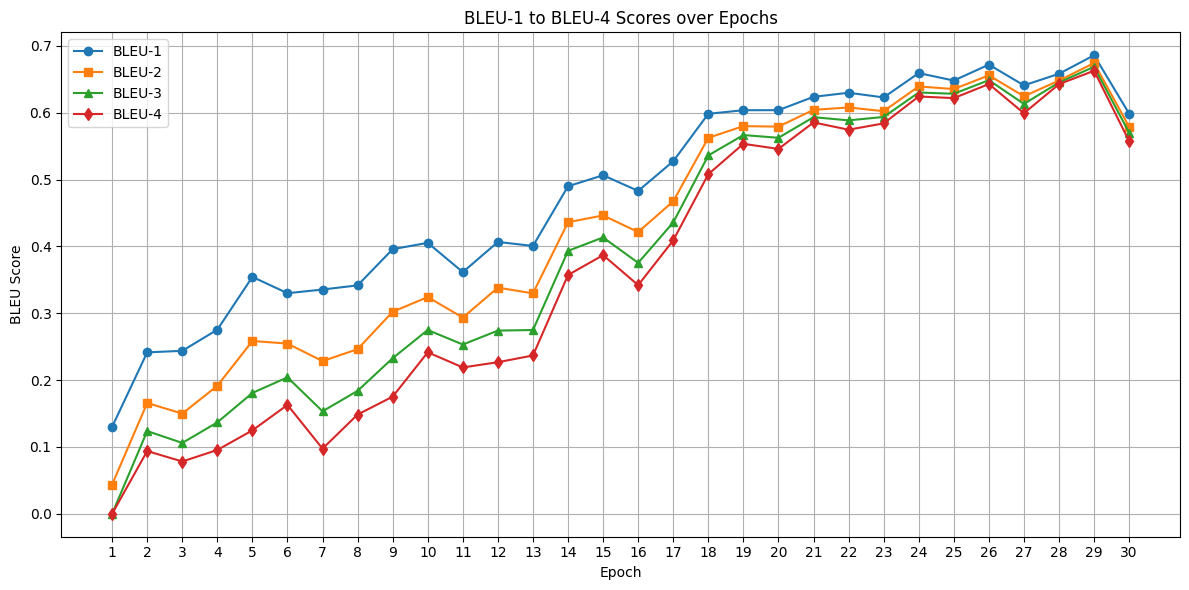

In [45]:
import matplotlib.pyplot as plt

# Example data from your training (replace with your actual scores if needed)
epochs = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 6))
plt.plot(epochs, bleu1_scores, label="BLEU-1", marker='o')
plt.plot(epochs, bleu2_scores, label="BLEU-2", marker='s')
plt.plot(epochs, bleu3_scores, label="BLEU-3", marker='^')
plt.plot(epochs, bleu4_scores, label="BLEU-4", marker='d')

plt.title("BLEU-1 to BLEU-4 Scores over Epochs")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


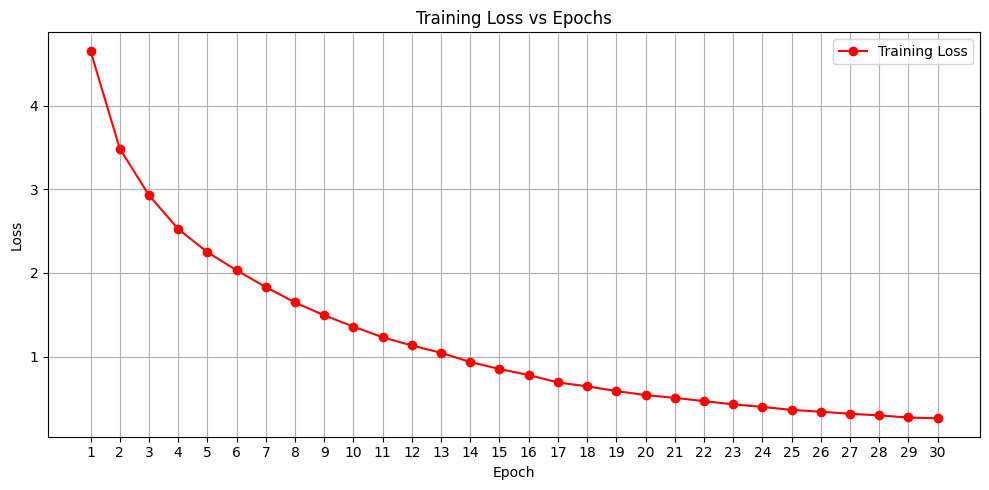

In [46]:
import matplotlib.pyplot as plt

epochs = list(range(1, EPOCHS + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, label="Training Loss", color='red', marker='o')
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


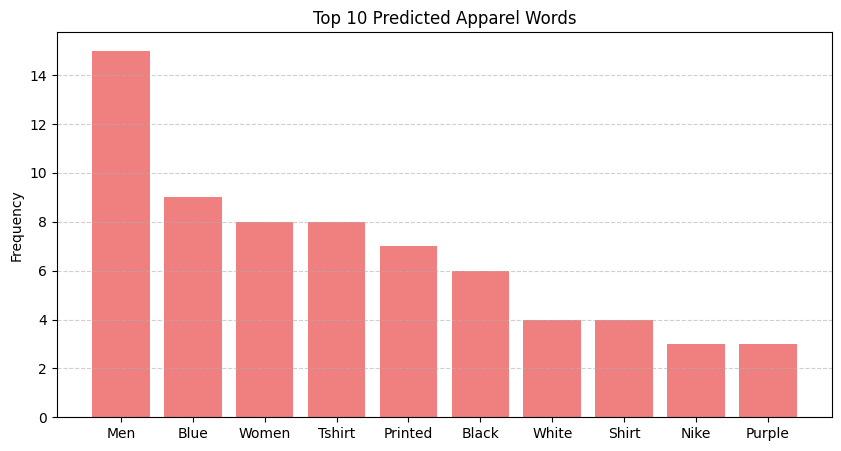

In [47]:
from collections import Counter

# Count most common words from predicted captions
all_pred_words = [word for caption in predicted_captions for word in caption]
common = Counter(all_pred_words).most_common(10)

labels, values = zip(*common)

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='lightcoral')
plt.title("Top 10 Predicted Apparel Words")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


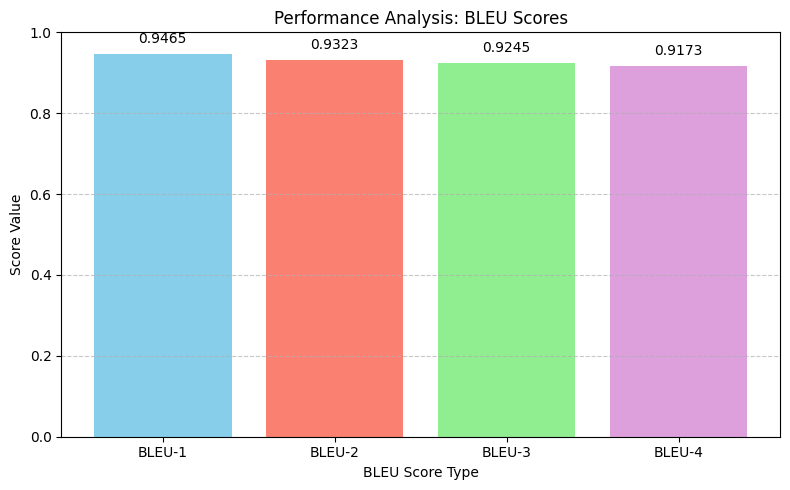

In [48]:
import matplotlib.pyplot as plt

# Replace these with your actual BLEU scores
bleu_scores = [0.9465, 0.9323, 0.9245, 0.9173]  # Example values
labels = ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, bleu_scores, color=['skyblue', 'salmon', 'lightgreen', 'plum'])
plt.ylim(0, 1.0)

# Annotate bars with score values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom')

plt.title("Performance Analysis: BLEU Scores")
plt.xlabel("BLEU Score Type")
plt.ylabel("Score Value")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [49]:
import pandas as pd

metrics_df = pd.DataFrame({
    'Epoch': epochs,
    'Loss': losses,
    'BLEU-1': bleu1_scores,
    'BLEU-2': bleu2_scores,
    'BLEU-3': bleu3_scores,
    'BLEU-4': bleu4_scores,
})

metrics_df.to_csv("epoch_metrics.csv", index=False)
print("✅ Saved metrics to epoch_metrics.csv")


✅ Saved metrics to epoch_metrics.csv


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/tmp/ipython-input-4076518963.py:81: UserWarning: Glyph 129532 (\N{BAR OF SOAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129532 (\N{BAR OF SOAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


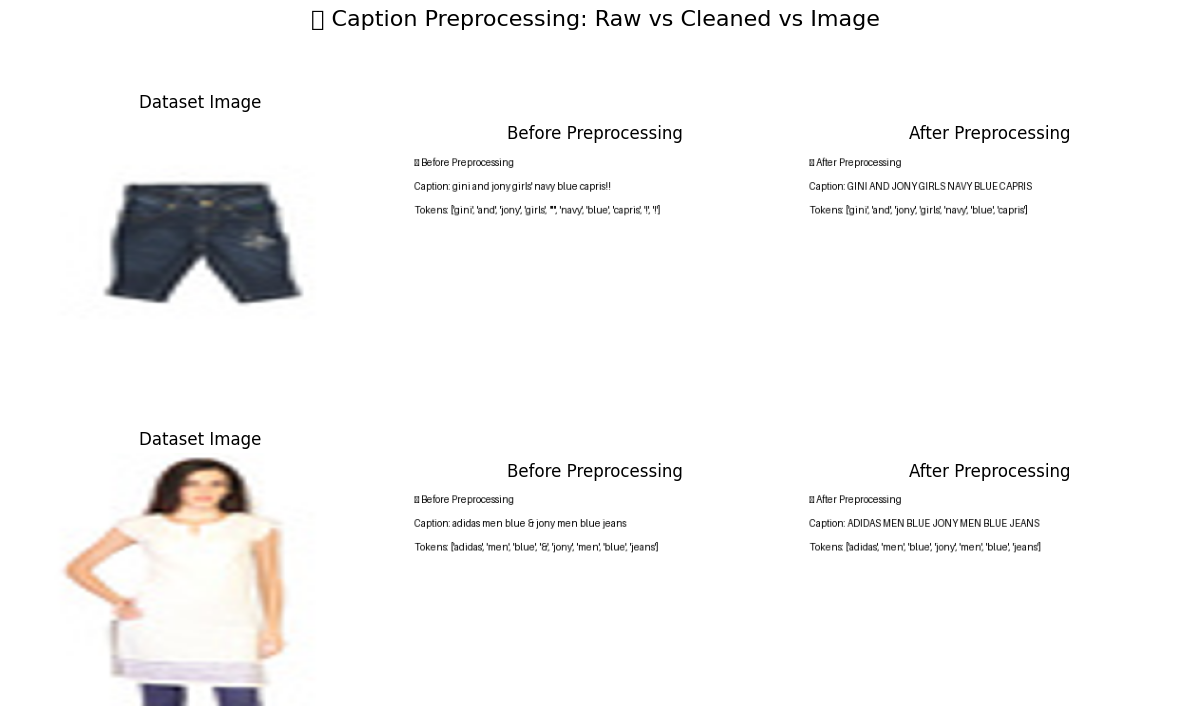

In [50]:
import matplotlib.pyplot as plt
import nltk
import re
from nltk.tokenize import word_tokenize
from PIL import Image, ImageDraw, ImageFont
import os

# Ensure NLTK tokenizer is downloaded
nltk.download('punkt')

# Sample captions and local image paths from your dataset
sample_data = [
    {
        "image_path": "fashion_data/images/46733.jpg",
        "caption": "Gini and Jony Girls' Navy Blue Capris!!"
    },
    {
        "image_path": "fashion_data/images/12069.jpg",
        "caption": "ADIDAS Men Blue & Jony Men Blue Jeans"
    },
]

# Define caption cleaning function
def clean_caption(caption):
    caption = re.sub(r"[^a-zA-Z0-9\s]", "", caption)
    caption = re.sub(r"\s+", " ", caption).strip()
    return caption.upper()

# Function to create a card-like image with text
def create_text_image(title, caption, tokens, width=400, height=200, font_size=16):
    img = Image.new('RGB', (width, height), color='white')
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()

    y = 10
    draw.text((10, y), title, fill="black", font=font)
    y += 25
    draw.text((10, y), f"Caption: {caption}", fill="black", font=font)
    y += 25
    draw.text((10, y), f"Tokens: {tokens}", fill="black", font=font)

    return img

# Create visualizations
plt.figure(figsize=(12, len(sample_data) * 4))

for i, entry in enumerate(sample_data):
    raw = entry['caption'].lower()
    cleaned = clean_caption(raw)
    tokens = word_tokenize(cleaned.lower())

    before_img = create_text_image("📝 Before Preprocessing", raw, word_tokenize(raw))
    after_img = create_text_image("✅ After Preprocessing", cleaned, tokens)

    # Load actual image from dataset
    image = Image.open(entry['image_path']).convert("RGB").resize((300, 200))

    # Show actual image
    plt.subplot(len(sample_data), 3, 3 * i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Dataset Image")

    # Show before preprocessing
    plt.subplot(len(sample_data), 3, 3 * i + 2)
    plt.imshow(before_img)
    plt.axis('off')
    plt.title("Before Preprocessing")

    # Show after preprocessing
    plt.subplot(len(sample_data), 3, 3 * i + 3)
    plt.imshow(after_img)
    plt.axis('off')
    plt.title("After Preprocessing")

plt.suptitle("🧼 Caption Preprocessing: Raw vs Cleaned vs Image", fontsize=16)
plt.tight_layout()
plt.show()


In [51]:
# Save only state_dict (recommended way)
torch.save(decoder.state_dict(), "fashion_caption_model.pth")

# Copy to Google Drive
import shutil
shutil.copy("fashion_caption_model.pth", "/content/drive/MyDrive/fashion_caption_model.pth")


'/content/drive/MyDrive/fashion_caption_model.pth'

In [52]:
pip install gradio opencv-python-headless


In [53]:
import gradio as gr
import torch
from PIL import Image
import cv2
import os
import tempfile
from torchvision import transforms

# ------------------- Setup -------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
decoder.load_state_dict(torch.load("fashion_caption_model.pth", map_location=device))
decoder.eval()

# Image transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Feature extractor (ConvNeXt-Large pretrained)
import timm
feature_model = timm.create_model("convnext_large", pretrained=True, num_classes=0).to(device)
feature_model.eval()

# Caption generation logic
def generate_caption_interface(image_pil):
    image_tensor = transform(image_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = feature_model(image_tensor).squeeze()
    caption = generate_caption(decoder, feature, word2idx, idx2word)
    return "🧾 Caption: " + " ".join(caption)

# Video captioning logic
def generate_captions_from_video(video_file):
    temp_dir = tempfile.mkdtemp()
    video_path = os.path.join(temp_dir, "input_video.mp4")
    with open(video_path, "wb") as f:
        f.write(video_file.read())

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    captions = []

    while True:
        ret, frame = cap.read()
        if not ret or frame_count > 12:  # Limit to 13 frames
            break
        if frame_count % 3 == 0:
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(image)
            image_tensor = transform(pil_img).unsqueeze(0).to(device)
            with torch.no_grad():
                feature = feature_model(image_tensor).squeeze()
            caption = generate_caption(decoder, feature, word2idx, idx2word)
            captions.append(f"🖼️ Frame {frame_count:03}: " + " ".join(caption))
        frame_count += 1
    cap.release()
    return "\n".join(captions)

# ------------------- Gradio Interface -------------------
image_captioning = gr.Interface(
    fn=generate_caption_interface,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="👕 Apparel Image Captioning"
)

video_captioning = gr.Interface(
    fn=generate_captions_from_video,
    inputs=gr.File(file_types=[".mp4"]),
    outputs="text",
    title="🎥 Apparel Video Captioning"
)

gr.TabbedInterface(
    [image_captioning, video_captioning],
    ["Image Captioning", "Video Captioning"]
).launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://78436b5a9f260d06d8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/tmp/ipython-input-4076518963.py:81: UserWarning: Glyph 129532 (\N{BAR OF SOAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129532 (\N{BAR OF SOAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


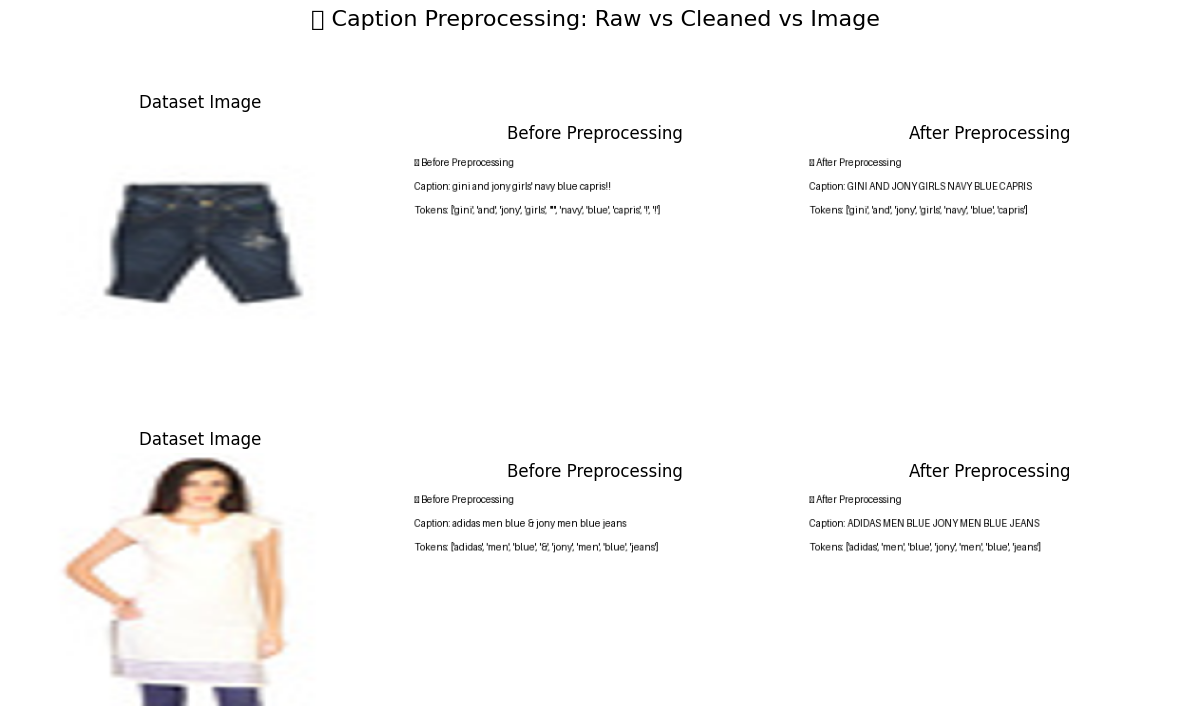

In [54]:
import matplotlib.pyplot as plt
import nltk
import re
from nltk.tokenize import word_tokenize
from PIL import Image, ImageDraw, ImageFont
import os

# Ensure NLTK tokenizer is downloaded
nltk.download('punkt')

# Sample captions and local image paths from your dataset
sample_data = [
    {
        "image_path": "fashion_data/images/46733.jpg",
        "caption": "Gini and Jony Girls' Navy Blue Capris!!"
    },
    {
        "image_path": "fashion_data/images/12069.jpg",
        "caption": "ADIDAS Men Blue & Jony Men Blue Jeans"
    },
]

# Define caption cleaning function
def clean_caption(caption):
    caption = re.sub(r"[^a-zA-Z0-9\s]", "", caption)
    caption = re.sub(r"\s+", " ", caption).strip()
    return caption.upper()

# Function to create a card-like image with text
def create_text_image(title, caption, tokens, width=400, height=200, font_size=16):
    img = Image.new('RGB', (width, height), color='white')
    draw = ImageDraw.Draw(img)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except:
        font = ImageFont.load_default()

    y = 10
    draw.text((10, y), title, fill="black", font=font)
    y += 25
    draw.text((10, y), f"Caption: {caption}", fill="black", font=font)
    y += 25
    draw.text((10, y), f"Tokens: {tokens}", fill="black", font=font)

    return img

# Create visualizations
plt.figure(figsize=(12, len(sample_data) * 4))

for i, entry in enumerate(sample_data):
    raw = entry['caption'].lower()
    cleaned = clean_caption(raw)
    tokens = word_tokenize(cleaned.lower())

    before_img = create_text_image("📝 Before Preprocessing", raw, word_tokenize(raw))
    after_img = create_text_image("✅ After Preprocessing", cleaned, tokens)

    # Load actual image from dataset
    image = Image.open(entry['image_path']).convert("RGB").resize((300, 200))

    # Show actual image
    plt.subplot(len(sample_data), 3, 3 * i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Dataset Image")

    # Show before preprocessing
    plt.subplot(len(sample_data), 3, 3 * i + 2)
    plt.imshow(before_img)
    plt.axis('off')
    plt.title("Before Preprocessing")

    # Show after preprocessing
    plt.subplot(len(sample_data), 3, 3 * i + 3)
    plt.imshow(after_img)
    plt.axis('off')
    plt.title("After Preprocessing")

plt.suptitle("🧼 Caption Preprocessing: Raw vs Cleaned vs Image", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
!zip -r ApparelCaptioningProject.zip ApparelCaptioningProject/

	zip warning: name not matched: ApparelCaptioningProject/

zip error: Nothing to do! (try: zip -r ApparelCaptioningProject.zip . -i ApparelCaptioningProject/)
